<a href="https://colab.research.google.com/github/Zhachory1/MusicNST/blob/master/ComposerClassifierWithPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install Dependencies
print 'Installing dependencies...'
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -q pyfluidsynth
!pip install py-midi pretty_midi

Installing dependencies...


In [2]:
#@title Import Data from GitHub 
!cd MusicNST/ && git pull
!git clone https://github.com/Zhachory1/MusicNST.git

Already up to date.
fatal: destination path 'MusicNST' already exists and is not an empty directory.


In [3]:
#@Title Imports
import os
import copy
import fnmatch
import numpy as np
import time
import argparse
import warnings
import midi
import pretty_midi
import pandas as pd
import collections
import random
import tensorflow as tf

from google.colab import files

# Note sequence to piano roll
from magenta.music.pianoroll_lib import PianorollSequence
import magenta.music.sequences_lib as seq_lib
import magenta.music as mm
import magenta.models.music_vae.data as data
from magenta.protobuf import music_pb2
from tensorflow import Graph, Session

from keras import optimizers, losses
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dense, Lambda, LSTM, RepeatVector, Bidirectional
from keras import backend as K
from keras.utils import Sequence
from keras import optimizers, objectives
from keras import backend, losses, utils
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Lambda, LSTM, RepeatVector
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D, Convolution1D
from keras import backend as K
from keras.utils import Sequence, to_categorical
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model  

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

def play(note_sequence):
  mm.play_sequence(note_sequence, synth=mm.fluidsynth)

def download(note_sequence, filename):
  mm.sequence_proto_to_midi_file(note_sequence, filename)
  files.download(filename)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12200081356864760654
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12917747216972248462
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2626900019919092181
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14800692839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10269008440172421570
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
#@Title Helper functions and global variables 

################################################################################
#                                 Constants 
################################################################################
BATCH_SIZE = 50
NUM_ITER = 25
DF_FNAME = 'midi_filename'
DF_FEATURES = 'midi_features'
DF_COMPOSER = 'canonical_composer'
DF_COMPOSER_INDEX = 'composer_idx'
DF_SPLIT = "split"
PATH_PREFIX = './MusicNST/midi_files/maestro-v1.0.0/'
INDEX_PATH = PATH_PREFIX + "maestro-v1.0.0.csv"
MAX_DIM = 500
COUNT_CUTTING = 0
################################################################################
#                    Helper Functions to manipulate input data. 
################################################################################

def new_note_sequence(steps_per_quarter, step_per_split):
  """Helper function to quickly create default NoteSequence proto"""
  qns = music_pb2.NoteSequence()
  qns.quantization_info.steps_per_quarter = steps_per_quarter
  qns.total_quantized_steps = step_per_split
  qns.total_time = 2 * int(step_per_split/steps_per_quarter)
  time_signature = qns.time_signatures.add()
  time_signature.numerator = 4
  time_signature.denominator = 4
  time_signature.time = 0
  tempo = qns.tempos.add()
  tempo.qpm = 120 # quarters per minute
  tempo.time = 0
  return qns
  

def split_note_sequences(note_sequence, bars_per_split=2, steps_per_quarter=4):
  """Splits note_sequences into new note sequence of length bars_per_split
  
  Given a note_sequence, we quantize it to steps_per_quarter notes in a beat. We
  then grab 16*bar_per_split steps into separate note_sequences, assuming that 
  the bars are in 4|4 time. Setting bars_per_split to 2 will return an array of 
  note sequences that are of length 32. 
  
  Args:
    note_sequence:      NoteSequence, input note sequence to split
    bars_per_split:     int, number of bars each output note sequence will have. 
    steps_per_quarter:  int, number of steps in each quarter note.
  Return
    np.array[NoteSequences] - output of note sequences of length 
                              bars_per_split*16
  """
  quantized_seq = mm.quantize_note_sequence(note_sequence, steps_per_quarter)
  # Copy QNS into it's own note_sequences, and clear out its notes. We 
  # are going to iterate over the notes until we hit split boundaries. 
  # Once we hit a boundary, we split any ongoing notes in two, one for
  # the new QNS we have been collecting and one for the new one we will 
  # make. Once the bar is completed, we will createa PianorollSequence
  # from it, and start on the next bar. 
  step_per_split = int(steps_per_quarter*4) * bars_per_split
  split_steps = range(0, quantized_seq.total_quantized_steps, step_per_split)
  current_split = 0
  steps_per_quarter = quantized_seq.quantization_info.steps_per_quarter 
  qns = new_note_sequence(steps_per_quarter, step_per_split)
  pianoroll_seqs = []
  extended_notes = new_note_sequence(steps_per_quarter, step_per_split)
  for note in quantized_seq.notes:
    if note.quantized_start_step >= split_steps[current_split] + step_per_split: 
      # End of split sections. Close up QNS and set up next split.
      pianoroll_seqs.append(copy.deepcopy(qns))
      qns = extended_notes
      extended_notes = new_note_sequence(steps_per_quarter, step_per_split)
      current_split += 1

    if note.quantized_end_step >= split_steps[current_split] + step_per_split:
      # Note extends past this split. Split the note into two notes. Add note
      # from note.start_step to end of current split. Save note from start of 
      # next split to note.end_step
      first_half = qns.notes.add()
      first_half.pitch = note.pitch
      first_half.quantized_start_step = note.quantized_start_step - split_steps[current_split] 
      first_half.quantized_end_step = step_per_split

      second_half = extended_notes.notes.add()
      second_half.pitch = note.pitch
      second_half.quantized_start_step = 0
      second_half.quantized_end_step = note.quantized_end_step - split_steps[current_split] 
    else:
      # This is the normal route, where we just copy the note from the
      # sequence into the new one.
      new_note = qns.notes.add()
      new_note.pitch = note.pitch
      new_note.quantized_start_step = note.quantized_start_step - split_steps[current_split] 
      new_note.quantized_end_step = note.quantized_end_step - split_steps[current_split] 
  pianoroll_seqs.append(copy.deepcopy(qns))

  return pianoroll_seqs

def midi_to_pianoroll(midi_filename):
  """Converts Midi Files into np.arrays and concats them.
  
  The arrays have the following types:
  active, weights, onsets, onset_velocities, active_velocities, offsets, 
  control_changes
  
  Args:
    midi_filename: string, filename
  Returns: 
    np.array - train tensor (33, 128, 7)
  """
  midi_file = pretty_midi.PrettyMIDI(midi_filename)
  note_seq = mm.midi_to_sequence_proto(midi_file)
  split_note_seqs = split_note_sequences(note_seq)
  final_array = []
  for note_seq in split_note_seqs:
    # This outputs (33, 128, 7) It's 33 instead of 32 because it adds an end 
    # token at the end of every sequence.
    pnt = seq_lib.sequence_to_pianoroll(
        note_seq, 2, data.MIN_MIDI_PITCH, data.MAX_MIDI_PITCH)
    # t_list = [pnt.active, pnt.weights, pnt.onsets, 
    #                               pnt.onset_velocities, pnt.active_velocities, 
    #                               pnt.offsets, pnt.control_changes]
    t_list = [pnt.onsets]                                  
    final_array.append(np.concatenate(t_list, axis=-1))
  return np.array(final_array)

def pianoroll_to_notes(pianoroll, opt_midi_file_name=""):
  """Helper to obtain note_seq."""
  note_seq = seq_lib.pianoroll_to_note_sequence(piano_roll, 2, 0)
  if opt_midi_file_name != "":
    download(note_seq, opt_midi_file_name)
  return note_seq

def load_midi_data_from_midi_files(filenames):
  """Loads files.
  Args:
    filenames: list of strings, midi filenames
  Returns: 
    pandas dataframe."""
  tensor_dict = collections.OrderedDict()
  index_array = []
  i = 0
  for mn in filenames:
    tensor_dict[mn]=midi_to_pianoroll(PATH_PREFIX+mn)
    index_array.append(i)
    i=i+1
  return tensor_dict


In [0]:
#@Title Define the VAE
def Encoder(x, input_dim, hidden_dim, latent_dim, epsilon_std):
    # LSTM encoding
    h = Bidirectional(LSTM(hidden_dim,  return_sequences=True))(x)
    h = Bidirectional(LSTM(hidden_dim, ))(h)
    

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        # Note that this batch size DOES NOT correlate with the batch size in 
        # the data generator classes.
        def grab_normal(unused_arg):
          return K.random_normal(shape=(latent_dim,), mean=0., stddev=epsilon_std)
        epsilon = K.map_fn(grab_normal, z_log_sigma, dtype=tf.float32)

        return z_mean + z_log_sigma * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    return Model(x, z_mean), z_mean, z_log_sigma, z  

def Decoder(z, timesteps, input_dim, hidden_dim, latent_dim):
    # Making reusable layers for botht the generator model and the VAE model
    decoder_h_1 = LSTM(hidden_dim, return_sequences=True)
    decoder_h_2 = LSTM(hidden_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    # VAE model
    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h_1(h_decoded)
    h_decoded = decoder_h_2(h_decoded)
    x_decoded_mean = decoder_mean(h_decoded)
    
    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h_1(_h_decoded)
    _h_decoded = decoder_h_2(_h_decoded)
    _x_decoded_mean = decoder_mean(_h_decoded)
    decoder = Model(decoder_input, _x_decoded_mean)
    
    # return generator model and outputs for VAE to use
    return decoder, x_decoded_mean
    
def VAE(input_dim, 
        timesteps,  
        hidden_dim, 
        latent_dim,
        epsilon_std=1.,
        compile=True):
    # Create 3 models, encoder, decoder, and the full VAE. They all share the 
    # same weights so I can use them all. 
    
    # Creating input everyone can use.
    x = Input(shape=(timesteps, input_dim,))
    
    # Pull encoder and decoder with variables we need.
    encoder, z_mean, z_log_sigma, z = Encoder(x, input_dim, hidden_dim, latent_dim, epsilon_std)
    decoder, x_decoded_mean = Decoder(z, timesteps, input_dim, hidden_dim, latent_dim)
    
    # Make VAE model
    vae = Model(x, x_decoded_mean)
    
    # Describe the loss function
    def vae_loss(x, x_decoded_mean):
        # Loss between x and reconstructed x.
        xent_loss = losses.binary_crossentropy(x, x_decoded_mean)
        # Divergence between z and a guassian function. 
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + 0.1 * kl_loss
        return loss

    if compile:
      vae.compile(optimizer='rmsprop', loss=vae_loss)
      
    return vae, encoder, decoder

In [6]:
vae, enc, dec = VAE(input_dim=128, 
    timesteps=33, 
    hidden_dim=64,
    latent_dim=64,
    epsilon_std=1.,
    compile=False)

vae.load_weights("model_bilstm_weights.h5")
enc.load_weights("encoder_bilstm_weights.h5")
dec.load_weights("decoder_bilstm_weights.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
!ls

 decoder_bilstm_weights.h5  'model_bilstm_weights (1).h5'   MusicNST
 encoder_bilstm_weights.h5   model_bilstm_weights.h5	    sample_data


In [8]:
files.upload()

{}

In [0]:
class ComposerPredictorDataGenerator(Sequence):
    """Generates data for Keras from MIDI files"""
    def __init__(self, list_IDs, labels, batch_size=8, dim=(33, 896),
                 shuffle=True, bars_per_split=2):
        """Initialization"""
        self.dim = dim
        self.labels = labels
        self.batch_size = batch_size # Number of FILES to read in at one time
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.bars_per_split = bars_per_split
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples""" # X : (n_samples, *dim)
        # Initialization
        X = []
        y = []

        # Generate data
        loaded_data = load_midi_data_from_midi_files(list_IDs_temp)
        for i, ID in enumerate(list_IDs_temp):
            # Store sample. We grab many samples from one midi. So we concat 
            # everything in the batch dimension. Even though we have a batch 
            # size of eight, we mean we are reading in 8 files. We split the 
            # midi at 2 bar increments, then each of split split will be apart 
            # of the batch.
            X_data = loaded_data[ID]
            X.append(X_data) 
            # If we wanted to store a labe, we would do it here.
            for _ in range(X_data.shape[0]):
              y.append(self.labels[ID])
        X = np.concatenate(X, axis=0)
        X = X[:BATCH_SIZE,:,:]
        Y = np.eye(NUM_UNIQUE_COMPOSERS)[y]
        Y = Y[:BATCH_SIZE,:]
        return X, Y

In [0]:
##@title Make data generators
df = pd.read_csv("MusicNST/midi_files/maestro-v1.0.0/maestro-v1.0.0.csv", 
                 usecols=[DF_COMPOSER,DF_SPLIT,DF_FNAME])
# unique_composers = df[DF_COMPOSER].unique()
# NUM_UNIQUE_COMPOSERS = len(unique_composers)
n=4
unique_composers = df[DF_COMPOSER].value_counts()[:n].index.tolist()
NUM_UNIQUE_COMPOSERS = len(unique_composers)

df_comp = pd.DataFrame(data={
    DF_COMPOSER_INDEX: range(len(unique_composers))},
                      index=unique_composers)

df = df.join(df_comp, on=DF_COMPOSER, how='inner')
df = df[[DF_SPLIT, DF_FNAME, DF_COMPOSER_INDEX]]

# Make test/train/validation split from our csv file will contain our golden
# ie the composer and the midi_filename
train_split = df.loc[df[DF_SPLIT]=="train"]
# train_split = train_split[[DF_FNAME]]
train_filenames = train_split[DF_FNAME].tolist()
train_labels = dict()
for a, b in zip(train_filenames, train_split[DF_COMPOSER_INDEX].tolist()):
  train_labels[a]=b
train_generator = ComposerPredictorDataGenerator(train_filenames, train_labels)


validation_split = df.loc[df[DF_SPLIT]=="validation"]
# validation_split = validation_split[[DF_FNAME]]
validation_filenames = validation_split[DF_FNAME].tolist()
validation_labels = dict()
for a, b in zip(validation_filenames, validation_split[DF_COMPOSER_INDEX].tolist()):
  validation_labels[a]=b
validation_generator = ComposerPredictorDataGenerator(validation_filenames, validation_labels)

test_split = df.loc[df[DF_SPLIT]=="test"]
# test_split = test_split[[DF_FNAME]]
test_filenames = test_split[DF_FNAME].tolist()
test_labels = dict()
for a, b in zip(test_filenames, test_split[DF_COMPOSER_INDEX].tolist()):
  test_labels[a]=b
test_generator = ComposerPredictorDataGenerator(test_filenames, test_labels)


In [0]:
#@Title Model 

def get_model(shape, use_batchnorm=False, use_dropout=False, fixed_model=None):
  ip = Input(batch_shape=shape)
  if fixed_model: 
    ip = Lambda(lambda x: K.expand_dims(x, axis=-1))(fixed_model.layers[-1].output)
    print ip.shape
  layer_2 = ip
  if use_batchnorm:
    layer_2 = BatchNormalization(axis=-1)(layer_2)
  layer_2 = Convolution1D(filters=64, kernel_size=32, activation='elu', padding='same')(layer_2)
  if use_dropout:
    layer_2 = Dropout(rate=0.1)(layer_2)
  layer_2 = Convolution1D(filters=16, kernel_size=8, activation='elu', padding='same')(layer_2)
  layer_2 = Convolution1D(filters=1, kernel_size=4, activation='elu', padding='same')(layer_2)
  layer_2 = Lambda(lambda x: K.squeeze(x, axis=-1))(layer_2)
  dense_1 = Dense(units=256, activation='elu')(layer_2)
  if use_dropout:
    layer_2 = Dropout(rate=0.1)(layer_2)
  dense_1 = Dense(units=32, activation='elu')(dense_1)
  dense_1 = Dense(units=NUM_UNIQUE_COMPOSERS, activation='elu')(dense_1)
  dense_1 = Dense(units=NUM_UNIQUE_COMPOSERS, activation='softmax')(dense_1)
  if fixed_model:
    return Model(fixed_model.layers[0].input, dense_1)
  return Model(ip, dense_1)

def ComposerClassifier(fixed_model=None):
  composer_model = get_model([BATCH_SIZE, 50, 64], use_batchnorm=False, use_dropout=False, fixed_model=fixed_model)
  composer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return composer_model

In [20]:
for layer in enc.layers:
  layer.trainable = False
model = ComposerClassifier(enc)

(?, 64, 1)


In [21]:
#@title Train model on dataset
history = model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    epochs=10,
                    workers=8)

print model.evaluate_generator(generator=test_generator,
                         use_multiprocessing=True,
                         workers=8)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
65/65 [==============================] - 229s 4s/step - loss: 1.4098 - acc: 0.3766 - val_loss: 1.4901 - val_acc: 0.2267
Epoch 2/10
65/65 [==============================] - 222s 3s/step - loss: 1.3379 - acc: 0.3538 - val_loss: 1.4949 - val_acc: 0.0533
Epoch 3/10
65/65 [==============================] - 268s 4s/step - loss: 1.3602 - acc: 0.2972 - val_loss: 1.5768 - val_acc: 0.2400
Epoch 4/10
65/65 [==============================] - 332s 5s/step - loss: 1.3481 - acc: 0.3240 - val_loss: 1.4246 - val_acc: 0.4467
Epoch 5/10
65/65 [==============================] - 327s 5s/step - loss: 1.3763 - acc: 0.2831 - val_loss: 1.3838 - val_acc: 0.1800
Epoch 6/10
65/65 [==============================] - 326s 5s/step - loss: 1.3335 - acc: 0.3166 - val_loss: 1.3419 - val_acc: 0.3767
Epoch 7/10
65/65 [==============================] - 334s 5s/step - loss: 1.3663 - acc: 0.2871 - val_loss: 1.4177 - val_acc: 0.1900
Epoch 8/10
65/65 [=================

In [0]:
from keras.utils import plot_model
plot_model(enc, to_file='enc.png', show_layer_names=True)

In [0]:
from IPython.display import Image
Image('enc.png')

In [0]:
# Output and save composer with preprocessing
model.save_weights("composer_with_preprocess.h5")

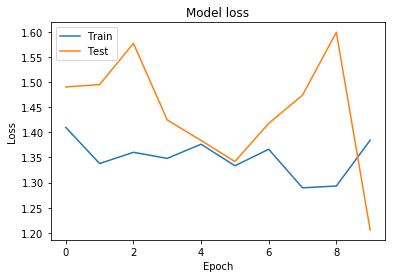

In [29]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()